In [1]:
import sys
import itertools

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
import helper.helper as h
import helper.methods as m

[[ 0.35  0.4   0.  ]
 [-0.5   0.3   0.  ]
 [ 0.    0.    0.5 ]]


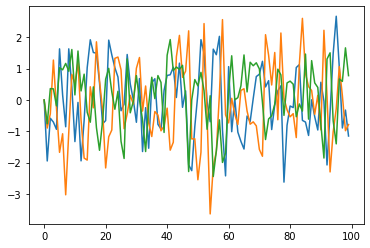

In [172]:
load = True

W_true, X = None, None

if load:
    # Get data name
    data_name = "X_s5_n100_T3_LASSO_example_0"

    # Load data
    W_true, X, expl = h.load_data(data_name)
print(W_true)
T, n = np.shape(X)
plt.plot(X)

In [178]:
W_dagols, W_ols = m._OLS_LINGNAM(X)
print(W_dagols)
print(W_ols)

[[ 0.          0.          0.        ]
 [-0.50362655  0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 0.28124079  0.4192033  -0.17500787]
 [-0.50362655  0.33206868 -0.00824465]
 [-0.0876024  -0.02158822  0.32196314]]


In [148]:
m._OMP_2(X[:-1], X[1:], max_coefs = int(1e10), tol = 0.0, verbose = False, output = False)

array([[ 0.53119852, -0.64214505,  0.02815081],
       [ 0.        ,  0.57399771, -0.19826744],
       [ 0.        ,  0.        ,  0.39729557]])

In [164]:
def _OMP_2(X, Y, max_coefs = int(1e10), tol = 0.0, verbose = False, output = False):
    
    def normalize(X): return X / np.linalg.norm(X, 2)
	
	# number of variables
    T, n = np.shape(X)
	
    # intialize F
    F = np.full((n, n), False)
    
    # forbidden indices
    N = set()
    
    # output
    Ws, mses, max_gains = [], [], []
    
    mses.append(1 / T * np.linalg.norm(Y - X @ np.zeros((n, n)), 'f') ** 2)
	
    # initialize beta
    W = np.zeros((n, n))
    
    # greedy for loop
    for coef in range(min(n ** 2, max_coefs)):
        
        # get the gains
        gains = np.array([np.abs(normalize(X[:, i]) @ ((X @ W)[:, j] - Y[:, j])) for j in range(n) for i in range(n)])
        
        # set the forbidden coefficients to negative value, so that they will never be chosen
        gains[list(N)] = -np.ones(len(list(N)))
        
        # find the index that maximizes the gains
        i_max = np.argmax(gains)

        # check if the gain is large enough
        if max(gains) <= tol: break
        
        # add index to F
        F[i_max % n][i_max // n] = True
        
        # get 2D indices based on flattened index i_max
        row, col = i_max % n, i_max // n
        
        # check if we still have a DAG
        if h.is_dag(F):   
            # if so, calculate new betas using only atoms in F
            X_F = X[:, F[:, col]]
            W[F[:, col], col] = np.linalg.inv(X_F.T @ X_F) @ X_F.T @ Y[:, col]
            
            # append to iterative list of W
            Ws.append(W.copy().reshape(n, n))
            
            # append max_gains
            max_gains.append(max(gains))
            
            # check the current mean squared error    
            mses.append(1 / T * np.linalg.norm(Y - X @ Ws[-1], 'f') ** 2)
        else:
            # if we do not have a DAG, we remove it, and add it to the forbidden list
            F[row][col] = False
            N.add(i_max)
        
        # print for feedback
        if verbose:
            print(f"MaxGain: {np.round(max(gains), 3)}.")
            print(f"Gain: {np.round(gains.reshape(n, n).T, 3)}.")
            print(f"W:\n{np.round(W, 3)}.\n")
            print(f"F: {F}.")
        
    # return W and extra infor if we care about it
    if output:
        return W.reshape(n, n), Ws, mses, max_gains
    
    # if we do not care about output, we only return betas
    return W
	

In [168]:
W_v1 = _OMP_2(X[:-1], X[1:], max_coefs = int(1e10), tol = 0.0, verbose = True, output = False)

MaxGain: 6.372.
Gain: [[3.437 4.486 1.925]
 [6.372 4.06  0.723]
 [0.594 1.119 3.186]].
W:
[[ 0.   0.   0. ]
 [-0.5  0.   0. ]
 [ 0.   0.   0. ]].

F: [[False False False]
 [ True False False]
 [False False False]].
MaxGain: 4.486.
Gain: [[3.139 4.486 1.925]
 [0.    4.06  0.723]
 [0.829 1.119 3.186]].
W:
[[ 0.   0.   0. ]
 [-0.5  0.   0. ]
 [ 0.   0.   0. ]].

F: [[False False False]
 [ True False False]
 [False False False]].
MaxGain: 4.06.
Gain: [[ 3.139 -1.     1.925]
 [ 0.     4.06   0.723]
 [ 0.829  1.119  3.186]].
W:
[[ 0.     0.     0.   ]
 [-0.5    0.319  0.   ]
 [ 0.     0.     0.   ]].

F: [[False False False]
 [ True  True False]
 [False False False]].
MaxGain: 3.186.
Gain: [[ 3.139 -1.     1.925]
 [ 0.     0.     0.723]
 [ 0.829  0.213  3.186]].
W:
[[ 0.     0.     0.   ]
 [-0.5    0.319  0.   ]
 [ 0.     0.     0.323]].

F: [[False False False]
 [ True  True False]
 [False False  True]].
MaxGain: 3.139.
Gain: [[ 3.139 -1.     1.951]
 [ 0.     0.     0.012]
 [ 0.829  0.213  

In [169]:
def _OMP_3(X, Y, max_coefs = int(1e10), tol = 0.0, verbose = False, output = False):
    
    def normalize(X): return X / np.linalg.norm(X, 2)
	
	# number of variables
    T, n = np.shape(X)
	
    # intialize F
    F = np.full((n, n), False)
    
    # forbidden indices
    N = set()
    
    # output
    Ws, mses, max_gains = [], [], []
    
    mses.append(1 / T * np.linalg.norm(Y - X @ np.zeros((n, n)), 'f') ** 2)
	
    # initialize beta
    W = np.zeros((n, n))
    
    # greedy for loop
    for coef in range(min(n ** 2, max_coefs)):
        
#         # get the gains
#         for i in range(n):
#             for j in range(n):
#                 residual = normalize((X @ W)[:, j] - Y[:, j])
#                 corr = np.abs(normalize(X[:, i]).dot(residual))
#                 print(corr)
                
        gains = np.array([np.abs(normalize(X[:, i]) @ (normalize((X @ W)[:, j] - Y[:, j]))) for j in range(n) for i in range(n)])
        
        # set the forbidden coefficients to negative value, so that they will never be chosen
        gains[list(N)] = -np.ones(len(list(N)))
        
        # find the index that maximizes the gains
        i_max = np.argmax(gains)

        # check if the gain is large enough
        if max(gains) <= tol: break
        
        # add index to F
        F[i_max % n][i_max // n] = True
        
        # get 2D indices based on flattened index i_max
        row, col = i_max % n, i_max // n
        
        # check if we still have a DAG
        if h.is_dag(F):   
            # if so, calculate new betas using only atoms in F
            X_F = X[:, F[:, col]]
            W[F[:, col], col] = np.linalg.inv(X_F.T @ X_F) @ X_F.T @ Y[:, col]
            
            # append to iterative list of W
            Ws.append(W.copy().reshape(n, n))
            
            # append max_gains
            max_gains.append(max(gains))
            
            # check the current mean squared error    
            mses.append(1 / T * np.linalg.norm(Y - X @ Ws[-1], 'f') ** 2)
        else:
            # if we do not have a DAG, we remove it, and add it to the forbidden list
            F[row][col] = False
            N.add(i_max)
        
        # print for feedback
        if verbose:
            print(f"MaxGain: {np.round(max(gains), 3)}.")
            print(f"Gain: {np.round(gains.reshape(n, n).T, 3)}.")
            print(f"W:\n{np.round(W, 3)}.\n")
            print(f"F: {F}.")
        
    # return W and extra infor if we care about it
    if output:
        return W.reshape(n, n), Ws, mses, max_gains
    
    # if we do not care about output, we only return betas
    return W
	

In [170]:
W_v2, Ws, mses, _ = _OMP_3(X[:-1], X[1:], max_coefs = 1000, tol = 0.0, verbose = True, output = True)

MaxGain: 0.567.
Gain: [[0.306 0.351 0.194]
 [0.567 0.318 0.073]
 [0.053 0.088 0.322]].
W:
[[ 0.   0.   0. ]
 [-0.5  0.   0. ]
 [ 0.   0.   0. ]].

F: [[False False False]
 [ True False False]
 [False False False]].
MaxGain: 0.351.
Gain: [[0.339 0.351 0.194]
 [0.    0.318 0.073]
 [0.09  0.088 0.322]].
W:
[[ 0.   0.   0. ]
 [-0.5  0.   0. ]
 [ 0.   0.   0. ]].

F: [[False False False]
 [ True False False]
 [False False False]].
MaxGain: 0.339.
Gain: [[ 0.339 -1.     0.194]
 [ 0.     0.318  0.073]
 [ 0.09   0.088  0.322]].
W:
[[ 0.281  0.     0.   ]
 [-0.488  0.     0.   ]
 [ 0.     0.     0.   ]].

F: [[ True False False]
 [ True False False]
 [False False False]].
MaxGain: 0.322.
Gain: [[ 0.    -1.     0.194]
 [ 0.     0.318  0.073]
 [ 0.094  0.088  0.322]].
W:
[[ 0.281  0.     0.   ]
 [-0.488  0.     0.   ]
 [ 0.     0.     0.323]].

F: [[ True False False]
 [ True False False]
 [False False  True]].
MaxGain: 0.318.
Gain: [[ 0.    -1.     0.208]
 [ 0.     0.318  0.001]
 [ 0.094  0.088 

In [171]:
h.score(X, W_v1, W_true);
print()
h.score(X, W_v2, W_true);

True Positive Rate: 0.8.
True Negative Rate: 0.5.
False Prediction Rate: 0.333
Accuracy: 0.667.
R-Squared: 0.21
Mean Squared Error: 3.095

True Positive Rate: 0.8.
True Negative Rate: 0.5.
False Prediction Rate: 0.333
Accuracy: 0.667.
R-Squared: 0.21
Mean Squared Error: 3.095


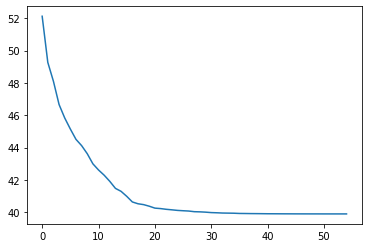

In [62]:
plt.plot([np.linalg.norm(X[1:] - X[:-1] @ W) for W in Ws])

In [63]:
def _K_OMP_output(X, Y, max_coefs = 1e10, tol = 0.0, tol_res = 0.0, verbose = False, output = False, normalize = False, F = [], is_sem = False):
    """Do Kernel OMP on X, Y."""
	
    def Lambda_to_adj(Lambda):
        """Convert Lambda list to adjacency matrix"""
        n = len(Lambda)
    
        adj_mat = np.zeros((n, n))
    
        for i, col in enumerate(Lambda):
            adj_mat[i, col] = 1 
    
        return adj_mat
    
	# get dimensions
    T, n = np.shape(X)
	
    if is_sem: F = [i * (n + 1) for i in range(n)]
    
	# compute kernel spaces
    Psi = X.T.dot(X)  					# p times p
    K = X.T.dot(Y)	  					# p  times p
    Theta = [y.T.dot(y) for y in Y.T] 	# 1 times 1

	
    # initialize Lambda, idx, betas
    Lambda, idx, betas = [[] for _ in range(n)], [], np.zeros((n, n))
    
	# compute norms if we want to normalize
    norms = [1] * n # initialize as harmless 1 array	
    if normalize: norms = [np.linalg.norm(x) for x in X.T]
	
    Ws = []
	
    # for each possible coefficient
    for i in range(n ** 2):    
    
        # compute gains
        gains = np.abs([(k - betas.T @ Psi[i, :]) / norms[i] for i, k in enumerate(K)])
        
        # set forbidden set to -1, impossible to pick then
        gains = gains.flatten()
		
        gains[F] = - np.ones(len(F))
        gains = gains.reshape(n, n)
		
        #print(gains.max())
		# stopping criterion
        # print(np.round(gains.max(), 1), end = "\t")
        if np.round(gains, 8).max() <= tol: break
		
        # append best atom to Lambda
		# if tie, pick the one that minimizes residual
        row, col = np.argmax(gains) // n, np.argmax(gains) % n
		
        if row not in Lambda[col]: Lambda[col].append(row)
    
        # check if we have a DAG, not super efficient
        if h.is_dag(Lambda_to_adj(Lambda)): 
            # update only column col, use indices of 
            idx = Lambda[col]
            Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]
        
            # speedup: add transpose to forbidden set
            F.append(col * n + row)

            # update betas        	
            betas[np.array(idx)[:, None], col] = np.linalg.inv(Psi_F) @ K[np.array(idx)[:, None], col]
			
            Ws.append(betas.copy())
			
            # print(np.round(betas[row][col], 1), end = "\t")
            # if np.abs(betas[row][col]) <= tol: break
            if len(np.nonzero(betas)[0]) >= max_coefs: break
            
        else:
            # append forbidden entry to forbidden list
            F.append(int(np.argmax(gains)))
            # remove coefficient from Lambda
            Lambda[col].remove(row)
    
		# check residual squared
        #print(sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)]))
		
        if sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)]) < tol_res:
            print("Residual Limit, terminate")
            break
		
        # print info if verbose
        if verbose:
            print(f"Iteration {i + 1}.\n")
            print(f"Gains:\n{np.round(gains, 3)}.\n")
            print(f"Beta_{i + 1}:\n{np.round(betas, 3)}.\n")
            print(f"Residual Squared: {np.round([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)], 32)}.\n\n")

    return betas, Ws, sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)])

A:
[[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]]

P:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]].

W:
[[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0

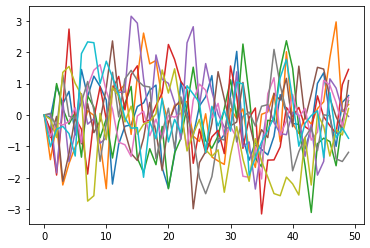

In [142]:
## Number of dimensions, number of edges, number of samples
T, n, s = 50, 10, 4

## Coefficient matrix
A_true = np.abs(h.generate_A(n, s, tril = False, low = 0.5, high = 0.5))

for i in range(n):
    A_true[i][i] = 0.5
    
## True permutation
P_true = np.identity(n)

W_true = P_true.T @ A_true @ P_true

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

# get X value and X prediction
X_val = X[1:]
X_pred = X[:-1]

print(f"A:\n{np.round(A_true, 2)}\n\nP:\n{P_true}.\n\nW:\n{np.round(W_true, 2)}")

In [143]:
help(h.score)

Help on function score in module helper.helper:

score(X, W, W_true, printing=True, rounding=3, is_sem=False)
    Score the weighted adjacency matrix "W" against the true W, "W_true".
    Two different score types:
        - Structural: TPR, FPR, etc.
        - Predictive: Loss.



In [144]:
W_v1 = _OMP_2(X[:-1], X[1:], max_coefs = int(1e10), tol = 0.0, verbose = False, output = False)
W_v2, Ws, mses, _ = _OMP_3(X[:-1], X[1:], max_coefs = 1000, tol = 0.0, verbose = False, output = True)

h.score(X, W_v1, W_true);
print()
h.score(X, W_v2, W_true);

True Positive Rate: 1.0.
True Negative Rate: 0.5.
False Prediction Rate: 0.818
Accuracy: 0.55.
R-Squared: 0.299
Mean Squared Error: 8.412

True Positive Rate: 1.0.
True Negative Rate: 0.5.
False Prediction Rate: 0.818
Accuracy: 0.55.
R-Squared: 0.3
Mean Squared Error: 8.402


In [145]:
print(np.round((W_v1 != 0) ^ (W_v2 != 0)))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [146]:
print(np.round(W_v1 != 0))
print(np.round(W_v2 != 0))

[[1. 1. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 1. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 1.]]
[[1. 1. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 0. 1. 1. 0. 0. 0. 1.]]
